In [ ]:
import pandas as pd
import numpy as np
import sklearn
import concurrent.futures
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import pickle as pkl
import h5py
import time
import gc

In [ ]:
RANDOM_STATE = 42

# Autoencoder

In [52]:
encounters = pd.read_hdf('./Data/encounters_agg.h5', 'encounters')

In [53]:
# Extract labels
y = encounters['1YEAR'].values

# drop label columns and convert to array
encounters = encounters.drop(['1YEAR', 'EID', 'SUBJECT_ID', 'HADM_ID'], axis=1).values

# normalize
X = MinMaxScaler(feature_range=(0, 1), copy=True).fit_transform(encounters)

In [43]:
latent_dim = 64
input_dim = encounters.shape[1]

class Autoencoder(Model):
    # Create initialization method for the class
    def __init__(self, latent_dim, input_dim):
        # Call initialization method for the parent class
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dropout(0.2),
            layers.Dense(1024, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(1024, activation='relu'),
            layers.Dense(input_dim, activation='relu')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
autoencoder = Autoencoder(latent_dim, input_dim)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(X, X, batch_size=256, epochs=20, shuffle=True)

Epoch 1/20
2184/2184 [==============================] - 20s 8ms/step - loss: 0.0591
Epoch 2/20
2184/2184 [==============================] - 18s 8ms/step - loss: 0.0501
Epoch 3/20
2184/2184 [==============================] - 18s 8ms/step - loss: 0.0472
Epoch 4/20
2184/2184 [==============================] - 18s 8ms/step - loss: 0.0455
Epoch 5/20
2184/2184 [==============================] - 18s 8ms/step - loss: 0.0443
Epoch 6/20
2184/2184 [==============================] - 18s 8ms/step - loss: 0.0435
Epoch 7/20
2184/2184 [==============================] - 18s 8ms/step - loss: 0.0430
Epoch 8/20
2184/2184 [==============================] - 18s 8ms/step - loss: 0.0425
Epoch 9/20
2184/2184 [==============================] - 18s 8ms/step - loss: 0.0418
Epoch 10/20
2184/2184 [==============================] - 18s 8ms/step - loss: 0.0415
Epoch 11/20
2184/2184 [==============================] - 18s 8ms/step - loss: 0.0413
Epoch 12/20
2184/2184 [==============================] - 18s 8ms/step - lo

In [23]:
encoded= autoencoder.encoder(X).numpy()

In [13]:
# Get the latent embedding from the autoencoder
#latent_embedding = keras.backend.function([autoencoder.encoder.layers[0].input], [autoencoder.encoder.layers[-1].output])(X)[0]
latent_embedding = autoencoder.encoder(X).numpy()

# Save latent embedding
latent_embedding.to_hdf('./Data/latent_embedding.h5', 'latent_embedding')

In [16]:
# access hidden layers and visualize
autoencoder.encoder.summary()
autoencoder.decoder.summary()

def get_encodings(layer):
    return keras.backend.function([autoencoder.encoder.layers[0].input], [autoencoder.encoder.layers[layer].output])

# Get embeddings for the desired number of admissions to be plotted for each layer of the encoder
num_samples_to_plot = 50000
encodings = [get_encodings(i)([X[:num_samples_to_plot]])[0] for i in range(len(autoencoder.encoder.layers))]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 1721)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1763328   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
Total params: 2,460,608
Trainable params: 2,460,608
Non-trainable params: 0
______________________________________________

### t-SNE

In [21]:
tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
with concurrent.futures.ProcessPoolExecutor() as executor:
    f0 = executor.submit(tsne.fit_transform, encodings[0])
    f1 = executor.submit(tsne.fit_transform, encodings[1])
    f2 = executor.submit(tsne.fit_transform, encodings[2])
    f3 = executor.submit(tsne.fit_transform, encodings[3])
    f4 = executor.submit(tsne.fit_transform, encodings[4])
    f5 = executor.submit(tsne.fit_transform, encodings[5])
    
    tsne_layer_0 = f0.result()
    tsne_layer_1 = f1.result()
    tsne_layer_2 = f2.result()
    tsne_layer_3 = f3.result()
    tsne_layer_4 = f4.result()
    tsne_layer_5 = f5.result()

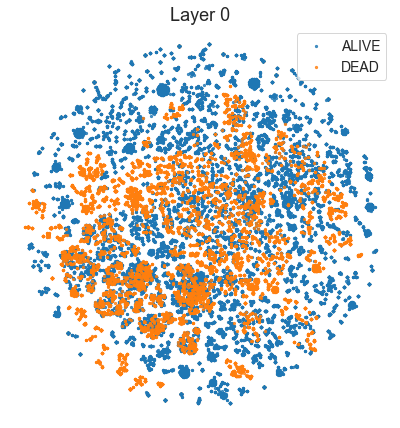

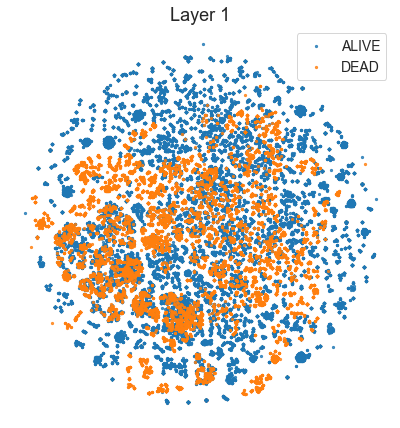

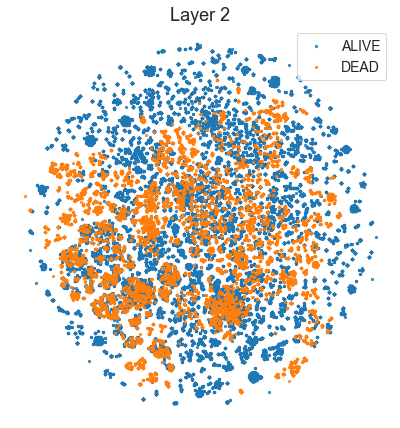

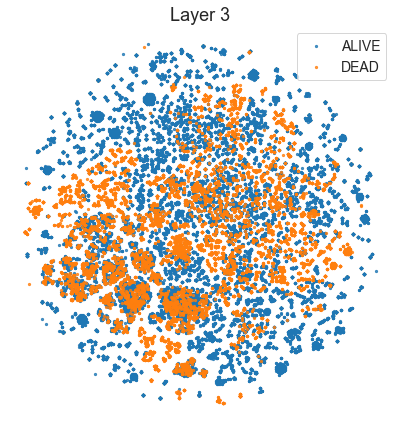

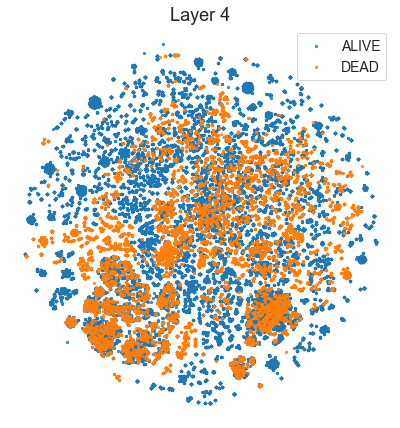

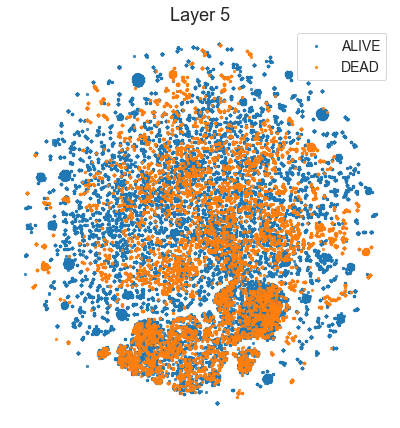

In [26]:
#Plot all layers of the encoder
dfs = []
for layer in [tsne_layer_0, tsne_layer_1, tsne_layer_2, tsne_layer_3, tsne_layer_4, tsne_layer_5]:
    df = pd.DataFrame(layer, columns=["x", "y"])
    df['SURVIVAL'] = y[:num_samples_to_plot]
    dfs.append(df)

for i, df in enumerate(dfs):
    g = sns.lmplot(x="x", y="y", hue='SURVIVAL', height=6, data=df, fit_reg=False, scatter_kws={"s": 5}, legend=False)
    g.set(yticks=[], xticks=[], xlabel='', ylabel='')
    plt.title(f'Layer {i}', fontsize=18)
    plt.legend(['ALIVE', 'DEAD'], fontsize=14, loc=1)
    sns.despine(left=True, bottom=True)
    plt.show()

## Feed Forward Neural Network Using Latent Embedding

### Pad Care Events

In [29]:
encounters = pd.read_hdf('./Data/encounters_agg.h5', 'encounters')
latent_embedding = pd.read_hdf('./Data/latent_embedding.h5', 'latent_embedding')

In [36]:
# Create a dataframe using the latent embedding from the autoencoder
e = pd.DataFrame(latent_embedding)
e['HADM_ID'] = encounters['HADM_ID']
e['1YEAR'] = encounters['1YEAR']

In [81]:
# Define the max number of care events per admission to train with
sequence_length = 70

encounter_list = []
y_list = []

# Loop through each admission
for admission in e.HADM_ID.unique():
    adm = e[e.HADM_ID == admission].copy()

    if adm.shape[1] > 0:
        # If patient survived less than 1 year after admission date append 1 to labels, else append 0
        y_list.append(adm['1YEAR'].head(1).values[0])
        adm.drop(['1YEAR', 'HADM_ID'], axis=1, inplace=True)

        encounter_list.append(adm.values.tolist())
        
X = sequence.pad_sequences(sequences=np.asarray(encounter_list, dtype=object), 
                           maxlen=sequence_length,
                           dtype='float32',
                           padding='post', 
                           truncating='post')
y = np.array(y_list)

In [83]:
print(X.shape)
print(X[0][:])

(7788, 35, 64)
[[0.09763906 0.         0.06501065 ... 0.         0.01165889 0.10172858]
 [0.09763908 0.         0.06501067 ... 0.         0.01165888 0.10172857]
 [0.09763909 0.         0.06501065 ... 0.         0.01165886 0.10172859]
 ...
 [0.02882099 0.0364316  0.03439709 ... 0.02204627 0.01825272 0.07765669]
 [0.00702875 0.01891062 0.05903944 ... 0.02198    0.07116068 0.0903847 ]
 [0.02882097 0.03643164 0.03439711 ... 0.0220463  0.0182527  0.07765669]]


In [84]:
h5f = h5py.File('./Data/Xy_embedding.h5', 'w')
h5f.create_dataset('X', data=X)
h5f.create_dataset('y', data=y)
h5f.close()

In [8]:
h5f = h5py.File('./Data/Xy_embedding.h5','r')
X = h5f['X'][:]
y = h5f['y'][:]
h5f.close()

### Train Model

In [ ]:
batch_size = 256

def mlp_fit_predict(X_train, y_train, X_test, y_test):    
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),
        layers.Dropout(0.5),
        layers.Dense(300, activation='relu'),
        layers.Dense(300, activation='relu'),
        layers.Dense(300, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['AUC']
                 )
    
    case_proportion = (1-(sum(y_train)/float(len(y_train))))
    
    class_weights = {0: 1-case_proportion, 1: case_proportion}
    print(class_weights)
    print(sum(y_train), len(y_train), float(sum(y))/len(y))
    
    early_stopping = EarlyStopping(monitor='loss', patience=3)
    
    model.fit(X_train, 
              y_train, 
              validation_data=(X_test, y_test), 
              epochs=100, 
              batch_size=batch_size, 
              callbacks=[early_stopping],
              class_weight=class_weights)
    
    model.summary()
    
    mlp_pred = model.predict(X_test)
    
    return roc_auc_score(y_test, mlp_pred, average='macro', sample_weight=None)

In [88]:
skf = StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)
roc_auc = {'mlp':[]}

for i, (train, test) in enumerate(skf.split(X,y)):
    roc_auc['mlp'].append(mlp_fit_predict(X[train], y[train], X[test], y[test], roc_auc))
    print('Cross fold: ', i, roc_auc)
print(roc_auc)

{0: 0.25939004815409317, 1: 0.7406099518459068}
1616 6230 0.2593733949666153
Epoch 1/100
25/25 [==============================] - 1s 22ms/step - loss: 0.2642 - auc: 0.5677 - val_loss: 0.6460 - val_auc: 0.6269
Epoch 2/100
25/25 [==============================] - 0s 10ms/step - loss: 0.2507 - auc: 0.6679 - val_loss: 0.6861 - val_auc: 0.6586
Epoch 3/100
25/25 [==============================] - 0s 10ms/step - loss: 0.2468 - auc: 0.6731 - val_loss: 0.6387 - val_auc: 0.6659
Epoch 4/100
25/25 [==============================] - 0s 10ms/step - loss: 0.2374 - auc: 0.6985 - val_loss: 0.6290 - val_auc: 0.6708
Epoch 5/100
25/25 [==============================] - 0s 9ms/step - loss: 0.2364 - auc: 0.7194 - val_loss: 0.6724 - val_auc: 0.6802
Epoch 6/100
25/25 [==============================] - 0s 10ms/step - loss: 0.2340 - auc: 0.7252 - val_loss: 0.6649 - val_auc: 0.6709
Epoch 7/100
25/25 [==============================] - 0s 10ms/step - loss: 0.2344 - auc: 0.7196 - val_loss: 0.6011 - val_auc: 0.6806


## Train Feed Forward Neural Network Using Latent Embedding and Varying Number of Care Events per Admission

In [39]:
np.random.seed(123)
mlp_embedding_scores = {}
# use cross fold from above, training separately to tune LSTM
# Define the max number of care events per admission to train with
for i in [1, 3, 5, 10, 20, 30, 50, 70]:
    encounter_list = []
    y = []

    # Loop through each admission
    for admission in e.HADM_ID.unique():
        adm = e[e.HADM_ID == admission].copy()

        if adm.shape[1] > 0:
            # If patient survived less than 1 year after admission date append 1 to labels, else append 0
            y.append(adm['1YEAR'].head(1).values[0])
            adm.drop(['1YEAR', 'HADM_ID'], axis=1, inplace=True)

            encounter_list.append(adm.values.tolist())

    X = sequence.pad_sequences(sequences=np.asarray(encounter_list, dtype=object), 
                               maxlen=i,
                               dtype='float32',
                               padding='post', 
                               truncating='post')
    y = np.array(y)

    
    # Train Model
    skf = StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)
    scores = {'mlp_embedding':[]}
    
    for j, (train, test) in enumerate(skf.split(X, y)):
        scores['mlp_embedding'].append(mlp_fit_predict(X[train], y[train], X[test], y[test]))
        print('Cross fold: ', j, scores)
    mlp_embedding_scores[i] = scores

pkl.dump(mlp_embedding_scores, open('./Model_Scores/mlp_embedding_scores.p', 'wb'))

{0: 0.27648351648351643, 1: 0.7235164835164836}
629 2275 0.27637130801687765
Epoch 1/100
9/9 [==============================] - 1s 50ms/step - loss: 0.2788 - auc: 0.5216 - val_loss: 0.6839 - val_auc: 0.5891
Epoch 2/100
9/9 [==============================] - 0s 14ms/step - loss: 0.2733 - auc: 0.5970 - val_loss: 0.6937 - val_auc: 0.6159
Epoch 3/100
9/9 [==============================] - 0s 13ms/step - loss: 0.2730 - auc: 0.6063 - val_loss: 0.6591 - val_auc: 0.6060
Epoch 4/100
9/9 [==============================] - 0s 13ms/step - loss: 0.2739 - auc: 0.6264 - val_loss: 0.6669 - val_auc: 0.6127
Epoch 5/100
9/9 [==============================] - 0s 13ms/step - loss: 0.2697 - auc: 0.6145 - val_loss: 0.6653 - val_auc: 0.6174
Epoch 6/100
9/9 [==============================] - 0s 13ms/step - loss: 0.2682 - auc: 0.6187 - val_loss: 0.6522 - val_auc: 0.6132
Epoch 7/100
9/9 [==============================] - 0s 13ms/step - loss: 0.2688 - auc: 0.6247 - val_loss: 0.6391 - val_auc: 0.6118
Epoch 8/100
9

In [41]:
mlp_embedding_scores

{1: {'mlp_embedding': [0.6146651413023313,
   0.665110382783996,
   0.6879444684929812,
   0.7103082940651082,
   0.6851937948455686]},
 3: {'mlp_embedding': [0.6587873353534104,
   0.694267515923567,
   0.6961381485375053,
   0.7296498198281438,
   0.702744587537]},
 5: {'mlp_embedding': [0.680492857584565,
   0.6932626306350876,
   0.6945303320759385,
   0.7523329945486465,
   0.7070063694267515]},
 10: {'mlp_embedding': [0.696911137220951,
   0.7143806814668234,
   0.6927988374250201,
   0.755520650466599,
   0.7021246919893999]},
 20: {'mlp_embedding': [0.6782202708552347,
   0.6685888318595015,
   0.706016943911941,
   0.740167544426992,
   0.6742293923473895]},
 30: {'mlp_embedding': [0.656901242965803,
   0.6626677385443077,
   0.6987508502875518,
   0.6695771351134928,
   0.6716568258248485]},
 50: {'mlp_embedding': [0.6533609547956217,
   0.7027085523467936,
   0.6567930245501206,
   0.64141180818627,
   0.6426922063632278]},
 70: {'mlp_embedding': [0.6460948611712325,
   0.68

Text(0, 0.5, 'AUC ROC')

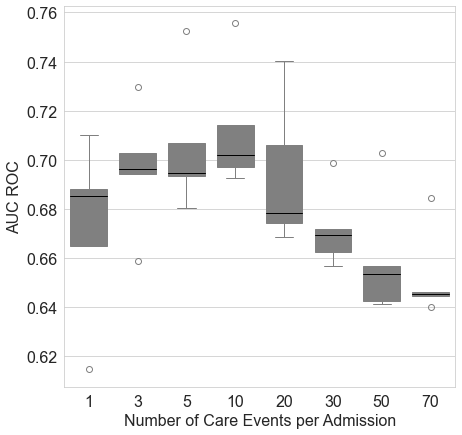

In [42]:
fig, axs = plt.subplots(figsize=(7,7))

plt.boxplot([mlp_embedding_scores[i]['mlp_embedding'] for i in [1, 3, 5, 10, 20, 30, 50, 70]], 
            labels=['1', '3', '5', '10', '20', '30', '50', '70'], 
            widths=0.75,
            patch_artist=True,
            boxprops=dict(facecolor='grey', color='grey'),
            capprops=dict(color='grey'),
            whiskerprops=dict(color='grey'),
            flierprops=dict(color='grey', markeredgecolor='grey'),
            medianprops=dict(color='black')
           )

plt.grid(axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Number of Care Events per Admission', fontsize=16)
plt.ylabel('AUC ROC', fontsize=16)

## LSTM Using Laten Embedding

In [ ]:
def lstm_fit_predict(X_train, y_train, X_test, y_test):    
    model = tf.keras.Sequential([
        # Return sequence is set to true for the first two layers. These will output the predictions from each node after each
        # care event has been passed through. This results in an output with equivalent dimensions to the input
        layers.LSTM(100, return_sequences=True, stateful=False, input_shape=(X_train.shape[1], X_train.shape[2]),
                    recurrent_dropout=0.4, dropout=0.5),
        layers.LSTM(50, return_sequences=True, dropout=0.5, recurrent_dropout=0.3, stateful=False),
        # Return sequence is set to false for the last layer. It outputs a vector that is the prediction
        # from each node after the final care event has been passed through.
        layers.LSTM(50, return_sequences=False, dropout=0.5, recurrent_dropout=0.3, stateful=False),
        # The output of the third LSTM layer is fed to a dense layer that will output the mortality prediction for the patient admission
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['AUC'])
    
    case_proportion = (1-(sum(y_train)/float(len(y_train))))
    class_weights = {0: 1-case_proportion, 1: case_proportion}
    
    early_stopping = EarlyStopping(monitor='loss', patience=3)
    
    model.fit(X_train, 
              y_train, 
              validation_data=(X_test, y_test), 
              epochs=100, 
              batch_size=256, 
              callbacks=[early_stopping],
              class_weight=class_weights)
    
    model.summary()
    
    lstm_pred = model.predict(X_test)
    
    return roc_auc_score(y_test, lstm_pred, average='macro', sample_weight=None)

In [90]:
skf = StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)
roc_auc = {'lstm':[]}

for j, (train, test) in enumerate(skf.split(X,y)):
    roc_auc['lstm'].append(lstm_fit_predict(X[train], y[train], X[test], y[test], roc_auc))
    print('Cross fold: ', j, roc_auc)
print(roc_auc)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 35, 100)           66000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 35, 50)            30200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 51        
Total params: 116,451
Trainable params: 116,451
Non-trainable params: 0
_________________________________________________________________
{0: 0.25939004815409317, 1: 0.7406099518459068}
1616 6230 0.2593733949666153
Epoch 1/100
25/25 [==============================] - 24s 769ms/step - loss: 0.2669 - auc: 0.5580 - val_loss: 0.6549 - val_auc: 0.6210
Epoch 2/100
25/25 [================

## Train LSTM Using Latent Embedding and Varying Number of Care Events per Admission

In [40]:
np.random.seed(123)
lstm_embedding_scores = {}
# use cross fold from above, training separately to tune LSTM
# Define the max number of care events per admission to train with
for i in [1, 3, 5, 10, 20, 30, 50, 70]:
    encounter_list = []
    y= []

    # Loop through each admission
    for admission in e.HADM_ID.unique():
        adm = e[e.HADM_ID == admission].copy()

        if adm.shape[1] > 0:
            # If patient survived less than 1 year after admission date append 1 to labels, else append 0
            y.append(adm['1YEAR'].head(1).values[0])
            adm.drop(['1YEAR', 'HADM_ID'], axis=1, inplace=True)

            encounter_list.append(adm.values.tolist())

    X = sequence.pad_sequences(sequences=np.asarray(encounter_list, dtype=object), 
                               maxlen=i,
                               dtype='float32',
                               padding='post', 
                               truncating='post')
    y = np.array(y)

    
    # Train Model
    skf = StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)
    scores = {'lstm_embedding':[]}
    
    for j, (train, test) in enumerate(skf.split(X, y)):
        scores['lstm_embedding'].append(lstm_fit_predict(X[train], y[train], X[test], y[test]))
        print('Cross fold: ', j, scores)
    lstm_embedding_scores[i] = scores

pkl.dump(lstm_embedding_scores, open('./Model_Scores/lstm_embedding_scores.p', 'wb'))

Epoch 1/100
9/9 [==============================] - 7s 125ms/step - loss: 0.2788 - auc: 0.5017 - val_loss: 0.6944 - val_auc: 0.5000
Epoch 2/100
9/9 [==============================] - 0s 47ms/step - loss: 0.2768 - auc: 0.5064 - val_loss: 0.6939 - val_auc: 0.5000
Epoch 3/100
9/9 [==============================] - 0s 47ms/step - loss: 0.2782 - auc: 0.5067 - val_loss: 0.6940 - val_auc: 0.5146
Epoch 4/100
9/9 [==============================] - 0s 47ms/step - loss: 0.2763 - auc: 0.5257 - val_loss: 0.6947 - val_auc: 0.6017
Epoch 5/100
9/9 [==============================] - 0s 48ms/step - loss: 0.2742 - auc: 0.5514 - val_loss: 0.6957 - val_auc: 0.5669
Epoch 6/100
9/9 [==============================] - 0s 47ms/step - loss: 0.2753 - auc: 0.5864 - val_loss: 0.6962 - val_auc: 0.6036
Epoch 7/100
9/9 [==============================] - 0s 47ms/step - loss: 0.2776 - auc: 0.5922 - val_loss: 0.6947 - val_auc: 0.6206
Epoch 8/100
9/9 [==============================] - 0s 47ms/step - loss: 0.2756 - auc: 0.5

In [43]:
lstm_embedding_scores

{1: {'lstm_embedding': [0.6164739348215942,
   0.6426009523220579,
   0.6672129120029682,
   0.6770765961378545,
   0.6682164055356673]},
 3: {'lstm_embedding': [0.6502226207408324,
   0.6579061282542823,
   0.6668727969822521,
   0.7036865933659798,
   0.6871077223487844]},
 5: {'lstm_embedding': [0.6663317049038402,
   0.6768907303197081,
   0.6726547523344258,
   0.708598971326496,
   0.6972120197746681]},
 10: {'lstm_embedding': [0.6855482035742997,
   0.6738296951332632,
   0.6846824562488405,
   0.7255998028889095,
   0.7096719202814326]},
 20: {'lstm_embedding': [0.693525446787459,
   0.6973903902046874,
   0.6905726300166966,
   0.7353167636822815,
   0.7206595688626467]},
 30: {'lstm_embedding': [0.6914847566631624,
   0.6967410797105931,
   0.6999721724073958,
   0.7244602543965013,
   0.7277573728826693]},
 50: {'lstm_embedding': [0.6997248160286933,
   0.6916548141735206,
   0.6678158431760559,
   0.7255074070652006,
   0.7285167449284796]},
 70: {'lstm_embedding': [0.67631

Text(0, 0.5, 'AUC ROC')

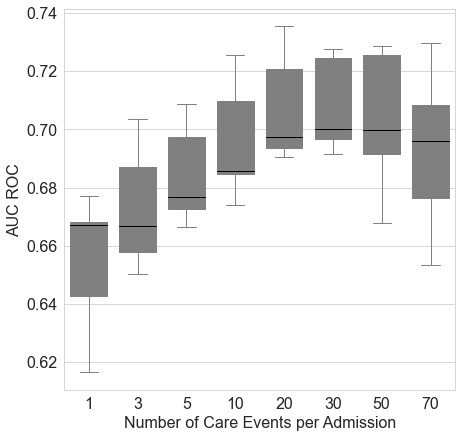

In [44]:
fig, axs = plt.subplots(figsize=(7,7))

plt.boxplot([lstm_embedding_scores[i]['lstm_embedding'] for i in [1, 3, 5, 10, 20, 30, 50, 70]], 
            labels=['1', '3', '5', '10', '20', '30', '50', '70'], 
            widths=0.75,
            patch_artist=True,
            boxprops=dict(facecolor='grey', color='grey'),
            capprops=dict(color='grey'),
            whiskerprops=dict(color='grey'),
            flierprops=dict(color='grey', markeredgecolor='grey'),
            medianprops=dict(color='black')
           )

plt.grid(axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Number of Care Events per Admission', fontsize=16)
plt.ylabel('AUC ROC', fontsize=16)